In [177]:
import numpy as np
import matplotlib.pyplot as plt
import radio_beam
from radio_beam import Beam
from spectral_cube import SpectralCube
from matplotlib import cm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from matplotlib.patches import Ellipse
from astropy import units as u 
from astropy import coordinates
from astropy.utils import data
from astropy.cosmology import LambdaCDM
#import pylab as pl
from astropy.io import ascii
from matplotlib import rcParams
#import aplpy
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as mtick
import pandas as pd
from astropy.coordinates import SkyCoord

In [178]:
tab1 = '~/Desktop/HI/COSMOS_32k.txt'
# Reading the data
data1 = pd.read_csv(tab1, comment='#', sep='\t')
# Setting the index of data1 to the 'Name' column
data1['Name_copy'] = data1['Name']
data1.set_index('Name', inplace=True)



In [183]:
cube_name = 'J100115.5+022858'
freq=data1.loc[cube_name, 'freq']*10**9 # central frequency of the source in the cubelet
cubelet=SpectralCube.read('~/Desktop/HI/COSMOS_r0p5/'+str(cube_name)+'_revised_masked_cube.fits')
restfr=1420.405*10**6 #HI rest frequency in HZ 
H0=67.5 #Hubble constant
c=299792 #speed of light
bmaj=cubelet.header['BMAJ']*3600 # values in the header are in degrees, so we need to convert them to arcsec
bmin=cubelet.header['BMIN']*3600
bpa=cubelet.header['BPA']
dpix=cubelet.header['CDELT2']*3600 #amount of arcsec per pixel
df=cubelet.header['CDELT3'] #hz

#Parameters to convert your flux from Jy/beam to Jy
omega = (np.pi*(bmaj/206265)*(bmin/206265))/(4*np.log(2))*4.25*10**10 # beam area in arcsec
bmpix=dpix**2/omega # amount of pixels per beam area- convertion factor, we will see it used later
#Formulas from the lecture
V=(restfr**2-freq**2)/(restfr**2+freq**2)*c # systemic velocity
dist=V/H0           #distance Mpc
z=(restfr-freq)/freq # redshift

#Convert cahnnel width from HZ to km/s
dv=(((restfr**2-(freq-df)**2)/(restfr**2+(freq-df)**2)*c))-V #channel width in km/s

print(dv) # check that all values make sence
V

-0.001244004215550376


21487.049458801128

In [180]:

cubelet = cubelet.with_spectral_unit(u.km/u.s,
                                       velocity_convention='radio',
                                       rest_value=1.420405*u.GHz)

# we define the new beam, which is 20 x 20 arcsec
beam = radio_beam.Beam(major=20*u.arcsec, minor=20*u.arcsec, pa=0*u.deg)
#then we convolve our original cubelet with the new beam
cube_20 = cubelet.convolve_to(beam)


In [181]:

# subcube_20=cube_20[:,1:20,1:20]

# rms = subcube_20.std(axis=(1,2))
# sigma=np.mean(rms.value)
# print(sigma)
# sigma=8e-05
# include_mask = cube_20 > 3*sigma*cube_20.unit

# mask_cube = cube_20.with_mask(include_mask)
# #you can save the mask and examine it in ds9 
# mask_cube.write('~/Desktop/HI/COSMOS_r0p5/'+str(cube_name)+'_revised_masked_cube.fits', format='fits',overwrite='True') 

check the spectrum & HI morphology

121
121
40


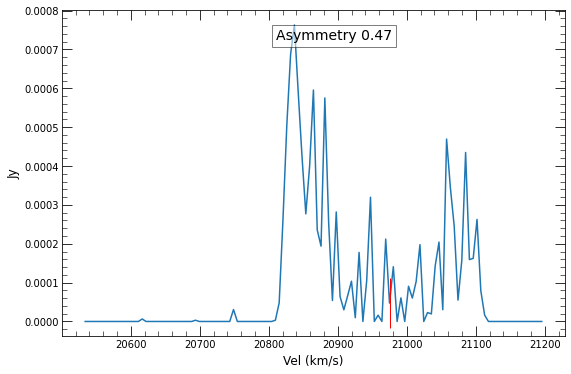

In [185]:
mask_cube= cubelet.with_spectral_unit(u.km/u.s,
                                       velocity_convention='radio',
                                       rest_value=1.420405*u.GHz)
spectrum_new_jy = mask_cube.sum(axis=(1,2))*bmpix
spectrum_new_jy_converted = np.nan_to_num(spectrum_new_jy.value)
v_arr1 = mask_cube.spectral_axis.value


#calculate asymmetry and store --------------------------------------
#asymmetry ratio calculation
left_sum=0
right_sum=0
#spectrum for 2,3,4,5 1=[0,8,14]2=[3,5,9] 3=[0,6,14] 4=[5,11,14] 5=[9,13,14]
i_begin = 0


spec_center=20

i_mid = int(len(v_arr1)/2)-spec_center
i_end = int(len(v_arr1))
print(i_end)
print(len(spectrum_new_jy_converted))

for i in range(i_begin,i_mid):
    left_sum=spectrum_new_jy_converted[i]+left_sum
for i in range(i_mid,i_end):    
    right_sum=spectrum_new_jy_converted[i]+right_sum


asymmetry = round(left_sum/right_sum,2)


# examine the spectrum
plt.figure(figsize=(9,6))
plt.plot(v_arr1, spectrum_new_jy_converted)
#plt.plot(v_arr1, spectrum_jy, label='Spectrum_unmasked')
#plt.plot([800, 25700], [0, 0],'k--')
print(i_mid)

plt.plot(v_arr1[i_mid], spectrum_new_jy_converted[i_mid], 'r|', markersize=50)

plt.xlabel('Vel (km/s)', fontsize = 12)
plt.ylabel('Jy', fontsize = 12)

x_pos = 0.97 * (v_arr1[72] - v_arr1[0]) + v_arr1[0]  # 10% into the x-range
y_pos = 0.95 * (max(spectrum_new_jy_converted) - min(spectrum_new_jy_converted))  # 10% into the y-range

x_pos_ = 0.97 * (v_arr1[72] - v_arr1[0]) + v_arr1[0]  # 10% into the x-range
y_pos_ = 0.85 * (max(spectrum_new_jy_converted) - min(spectrum_new_jy_converted))  # 10% into the y-range

plt.text(x_pos, y_pos, 'Asymmetry ' +str(asymmetry), fontsize=14, bbox=dict(facecolor='white', alpha=0.5))


plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().tick_params(axis='both', which='major', direction='in', length=10, top=True, right=True)
plt.gca().tick_params(axis='both', which='minor', direction='in', length=5, top=True, right=True)

#plt.legend(loc=2, numpoints=1, prop={'size':12})

plt.savefig('/Users/apple/Desktop/HI/COSMOS_r0p5_spectrum/'+str(cube_name)+'_spectrum.png',format = 'pdf', bbox_inches = 'tight', transparent=True)

plt.show()






In [186]:
tab1 = '~/Desktop/HI/COSMOS_32k_asy.txt'
# Reading the data
data1 = pd.read_csv(tab1, comment='#', sep='\t')
# Setting the index of data1 to the 'Name' column
#data1.set_index('Name', inplace=True)
data1['Name'] = data1['Name_copy']
data1.set_index('Name', inplace=True)

data1.loc[cube_name, 'spec_center'] = spec_center
data1.loc[cube_name, 'asy'] = asymmetry
data1.to_csv("~/Desktop/HI/COSMOS_32k_asy.txt", index=False, sep='\t')

In [187]:
data1=data1.fillna(0)
data1.to_csv("~/Desktop/HI/COSMOS_32k_asy.txt", index=False, sep='\t')

In [104]:
#velocity plot to check the asymmetry ratio
moment_0 = mask_cube.moment(order=0) 
moment_0.hdu  #it is important so you can use coordinates for the plots
moment_1=mask_cube.moment(order=1)
moment_1.hdu
atoms=(1.1*10**24*((moment_0)/(bmaj*bmin)))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111,projection=atoms.wcs)
#cmap = cm.RdBu_r
cmap=plt.get_cmap('RdBu_r',25)
#cmap.set_bad('white')
im = ax.imshow(moment_1.value,origin='lower', cmap=cmap, vmin=V-900, vmax=V-850)

contours = ax.contour(moment_1.value,levels=(83,15300,15350), colors=['white'], linewidths=1)
contours1 = ax.contour(moment_1.value,levels=(8325, 8325.2), colors=['black'], linewidths=1)
ax.set_xlabel("RA ", fontsize=10)
ax.set_ylabel("Dec", fontsize=10)
cb = plt.colorbar(mappable=im)
cb.set_label(r'Vel km/s')
#cb.add_lines(contours)
#cb.add_lines(contours1)
#cb.add_lines(contours)

el = Ellipse((6, 7), bmaj, bmin,angle=bpa, edgecolor='black',hatch='//', facecolor='none')
ax.add_patch(el)
#ax.invert_yaxis()  # Flips the Y axi
#plt.savefig('/Users/apple/Astro/revised_velocity/'+str(cube_name)+'_revised_velocity.png',format = 'png',\
 #            bbox_inches = 'tight', transparent=True)
plt.show()

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


KeyboardInterrupt: 

Asymmetry ratio calculated, add to catalogue

In [ ]:


tab1 = '~/Desktop/HI/COSMOS_32k_asy.txt'
# Reading the data
data1 = pd.read_csv(tab1, comment='#', sep='\t')
# Setting the index of data1 to the 'Name' column
#data1.set_index('Name', inplace=True)
data1['Name'] = data1['Name_copy']
data1.set_index('Name', inplace=True)

#data1.loc[cube_name, 'asy'] = asymmetry

print(data1.loc[cube_name, 'asy'])
data1.to_csv("~/Desktop/HI/COSMOS_32k_asy.txt", index=False, sep='\t')


2.09
